In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import networkx as nx

In [3]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [146]:
from src.nettack.GCN import *
from src.nettack.utils import *
from src.nettack.nettack import *

[autoreload of src.nettack.nettack failed: Traceback (most recent call last):
  File "/home/raphaelg/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/raphaelg/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/raphaelg/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/raphaelg/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/home/raphaelg/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 312, in update_instances
    update_instances(old, new, obj.__dict__, visited)
  File "/home/raphaelg/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 312, in update_instances
    

# Tests

## Layers

In [5]:
layer = GraphConvolution(in_features=8, out_features=5)

In [6]:
N = 30
Adjacency_matrix = torch.tensor((np.random.rand(N, N) > 0.7).astype(np.float32)).to_sparse()
input = torch.rand(N, 8).to_sparse()

In [7]:
layer(input, Adjacency_matrix).shape

torch.Size([30, 5])

## GCN

In [8]:
N = 30
C = 5
D = 20
Adjacency_matrix = torch.tensor((np.random.rand(N, N) > 0.7).astype(np.float32)).to_sparse()

X_observed = torch.rand(N, D)
Y_observed = torch.randint(low=0, high=C, size=(N,))

H = 10

In [9]:
gcn = GCN(sizes=[H, C],
          An=Adjacency_matrix,
          X_obs=X_observed,
          name='test', with_relu=True, params_dict={})

In [10]:
gcn_model = GCN_Model(gcn, lr=1e-3)

In [11]:
node_ids = torch.tensor([1, 3, 7])
node_labels = torch.tensor([2, 0, 3])

In [12]:
train_nodes = [1, 2, 5, 6, 7, 9, 15]
val_nodes = [17, 18, 19, 20, 22]

In [13]:
gcn_model.train(split_train=train_nodes, split_val=val_nodes, Z_obs=Y_observed)

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


converged after 18 iterations


## Random

In [14]:
node_labels = pd.read_csv('datasets/citeseer/citeseer.node_labels', header=None, names=['id', 'label'])

In [15]:
edges = pd.read_csv('datasets/citeseer/citeseer.edges', header=None, names=['e1', 'e2', 'weight'])

In [16]:
G = nx.Graph()
for _, row in node_labels.iterrows():
    G.add_node(row.id, label=row.label)
G.add_edges_from(edges.loc[:, ['e1', 'e2']])

## Nettack

### Data preprocessing

In [19]:
_A_obs, _X_obs, _z_obs = load_npz('src/data/citeseer.npz')

In [20]:
# Adjacency matrix
_A_obs

<3312x3312 sparse matrix of type '<class 'numpy.float32'>'
	with 4715 stored elements in Compressed Sparse Row format>

In [21]:
# Feature matrix
_X_obs

<3312x3703 sparse matrix of type '<class 'numpy.int64'>'
	with 105165 stored elements in Compressed Sparse Row format>

In [22]:
np.array(_X_obs[0].todense())[0].shape

(3703,)

In [23]:
# Labels
_z_obs
pd.value_counts(_z_obs)

2    701
4    668
1    596
5    590
3    508
0    249
dtype: int64

In [24]:
# Normalizing Adjacency matrix
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1

In [25]:
# For the algorithm to work, we have to consider a connected graph.
lcc = largest_connected_components(_A_obs)

Selecting 1 largest connected components


In [26]:
print(f'Largest connected component has {len(lcc)} nodes')
# keeping the largest connected component of the graph
_A_obs = _A_obs[lcc][:,lcc]
_X_obs = _X_obs[lcc].astype('float32')
_z_obs = _z_obs[lcc]

Largest connected component has 2110 nodes


In [27]:
assert np.abs(_A_obs - _A_obs.T).sum() == 0, "Input graph is not symmetric"
assert _A_obs.max() == 1 and len(np.unique(_A_obs[_A_obs.nonzero()].A1)) == 1, "Graph must be unweighted"
assert _A_obs.sum(0).A1.min() > 0, "Graph contains singleton nodes"

In [28]:
_N = _A_obs.shape[0]
_K = _z_obs.max()+1

# In our pytorch implementation, labels are not one hot encoded
# _Z_obs = np.eye(_K)[_z_obs]
_Z_obs = _z_obs
# Normalizing adjacency matrix
_An = preprocess_graph(_A_obs)
sizes = [16, _K]
degrees = _A_obs.sum(0).A1


np.random.seed(seed)

In [29]:
unlabeled_share = 0.8
val_share = 0.1
train_share = 1 - unlabeled_share - val_share
splits = train_val_test_split_tabular(np.arange(_N), train_size=train_share,
                                      val_size=val_share, test_size=unlabeled_share,
                                      stratify=_z_obs)
split_train, split_val, split_unlabeled = splits

In [30]:
print(f'Number of training node : {len(split_train)}')
print(f'Number of validation nodes : {len(split_val)}')
print(f'Number of unlabeled (unknown) nodes : {len(split_unlabeled)}')

Number of training node : 210
Number of validation nodes : 211
Number of unlabeled (unknown) nodes : 1688


### Choosing the node to attack

In [147]:
u = 0 # node to attack
assert u in split_unlabeled

### Train surrogate model

Initialization of Nettack : train on a simple model (with no ReLU) the weights of the GCN.

In [148]:
def sparse_numpy2sparse_torch(x):
    x = x.tocoo()
    values = x.data
    indices = np.vstack((x.row, x.col)).astype(float)
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = x.shape
    return torch.sparse.FloatTensor(i, v, torch.Size(shape))

In [149]:
An = sparse_numpy2sparse_torch(_An)
X_obs = sparse_numpy2sparse_torch(_X_obs)

In [150]:
surrogate_nn = GCN(sizes, An, X_obs, with_relu=False, name="surrogate")

In [151]:
surrogate_model = GCN_Model(surrogate_nn, lr=1e-2)

In [152]:
split_train = np.array(split_train).astype(np.int64)
split_val = np.array(split_val).astype(np.int64)

In [153]:
surrogate_model.train(split_train, split_val, torch.tensor(_Z_obs.astype(np.int64)), print_info=False)

In [154]:
preds = surrogate_model.predictions.detach().cpu().numpy().argmax(axis=1)
truth = _Z_obs[split_val]
(truth == preds).mean()

0.6540284360189573

In [155]:
W1 = surrogate_model.gcn.gc1.weight
W2 = surrogate_model.gcn.gc2.weight

### Setup attack

In [156]:
nettack = Nettack(_A_obs, _X_obs, _z_obs, W1, W2, u, verbose=True)

### Poison the data

In [157]:
nettack.reset()

In [158]:
direct_attack = False
n_influencers = 1 if direct_attack else 5
n_perturbations = int(degrees[u])+2 # How many perturbations to perform. Default: Degree of the node
perturb_features = False
perturb_structure = True

### Poison the data

For M=25, the first two perturbations are done in a different order, the rest stays the same. For M=5, the modifications are the same. This proves that the look ahead algorithm is correct and can only improve the performance 

In [159]:
nettack.attack_surrogate(n_perturbations,
                         perturb_structure=perturb_structure,
                         perturb_features=perturb_features,
                         direct=direct_attack,
                         n_influencers=n_influencers,
                        look_ahead=True,
                         M=10)

##### Starting attack #####
##### Attack only using structure perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 14 perturbations #####


/home/raphaelg/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected set' found for argument 'edges_set' of function 'compute_new_a_hat_uv'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "src/nettack/nettack.py", line 637:
def compute_new_a_hat_uv(edge_ixs, node_nb_ixs, edges_set, twohop_ixs, values_before, degs, potential_edges, u):
    """
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Influencer nodes: [2012  285 1437 1436  850]
Using the greedy look ahead algorithm
##### ...1/14 perturbations ... #####
##### ...3/14 perturbations ... #####
##### ...5/14 perturbations ... #####
##### ...7/14 perturbations ... #####
##### ...9/14 perturbations ... #####
##### ...11/14 perturbations ... #####
##### ...13/14 perturbations ... #####


In [160]:
print(nettack.structure_perturbations)

[(285, 627), (2012, 150), (1436, 1937), (285, 661), (2012, 1304), (1436, 698), (2012, 1577), (850, 412), (2012, 1529), (2012, 847), (285, 1431), (1436, 651), (1436, 1437), (1437, 1501)]


In [161]:
print(nettack.feature_perturbations)

[(), (), (), (), (), (), (), (), (), (), (), (), (), ()]


[(285, 1937), (2012, 1501), (285, 1925), (1436, 1004), (2012, 939), (1436, 578), (2012, 1051), (1063, 1309), (285, 1092), (2012, 1529), (2012, 847), (1063, 1873), (1436, 254), (2012, 781)]

[(285, 1501), (2012, 1937), (285, 1925), (894, 1004), (1436, 939), (2012, 578), (1436, 1051), (2012, 1309), (894, 1092), (285, 1873), (2012, 1529), (2012, 847), (1436, 254), (2012, 781)]

### Train GCN without perturbations

In [162]:
retrain_iters=5

In [163]:
classification_margins_clean = []
class_distrs_clean = []

u_nodes = torch.tensor([nettack.u])
u_labels = torch.tensor(_Z_obs.astype(np.int64))[u_nodes]
one_hot_encod_u = np.zeros(np.max(_Z_obs)+1)
one_hot_encod_u[_Z_obs[nettack.u]] = 1


for _ in range(retrain_iters):
    print("... {}/{} ".format(_+1, retrain_iters))
    gcn_before_nn = GCN(sizes, An, X_obs, with_relu=True,
                   name="gcn_orig")
    gcn_before = GCN_Model(gcn_before_nn, lr=1e-2)
    gcn_before.train(split_train, split_val, torch.tensor(_Z_obs.astype(np.int64)), print_info=False)
    preds = gcn_before.predictions.detach().cpu().numpy().argmax(axis=1)
    truth = _Z_obs[split_val]
    print(f'Validation accuracy : {(truth == preds).mean():.3f}')
    gcn_before._compute_loss_and_backprop(u_nodes, u_labels, False)
    probs_before_attack = gcn_before.predictions.detach().cpu().numpy()[0]

    class_distrs_clean.append(probs_before_attack)
    best_second_class_before = (probs_before_attack - 1000*one_hot_encod_u).argmax()
    margin_before = probs_before_attack[_z_obs[nettack.u]] - probs_before_attack[best_second_class_before]
    classification_margins_clean.append(margin_before)
class_distrs_clean = np.array(class_distrs_clean)

... 1/5 


/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy : 0.668
... 2/5 
Validation accuracy : 0.673
... 3/5 
Validation accuracy : 0.673
... 4/5 
Validation accuracy : 0.673
... 5/5 
Validation accuracy : 0.664


### Train GCN with perturbations

In [164]:
classification_margins_corrupted = []
class_distrs_retrain = []

nettack_adj_torch = sparse_numpy2sparse_torch(nettack.adj_preprocessed)
nettack_X_torch = sparse_numpy2sparse_torch(nettack.X_obs.tocsr())

for _ in range(retrain_iters):
    print("... {}/{} ".format(_+1, retrain_iters))
    gcn_retrain_nn = GCN(sizes, nettack_adj_torch, nettack_X_torch, with_relu=True,
                   name="gcn_retrain")
    gcn_retrain = GCN_Model(gcn_retrain_nn, lr=1e-2)

    gcn_retrain.train(split_train, split_val, torch.tensor(_Z_obs.astype(np.int64)), print_info=False)
    gcn_retrain._compute_loss_and_backprop(u_nodes, u_labels, False)
    probs_after_attack = gcn_retrain.predictions.detach().cpu().numpy()[0]
    class_distrs_retrain.append(probs_after_attack)
    best_second_class_after = (probs_after_attack - 1000*one_hot_encod_u).argmax()
    margin_after = probs_after_attack[_z_obs[nettack.u]] - probs_after_attack[best_second_class_after]
    classification_margins_corrupted.append(margin_after)
class_distrs_retrain = np.array(class_distrs_retrain)

... 1/5 
... 2/5 
... 3/5 
... 4/5 
... 5/5 


### Visualize results

In [165]:
classification_margins_corrupted, classification_margins_clean

([-0.22779733, 0.5347599, 0.5697336, 0.28081816, 0.15417907],
 [0.9890154, 0.96311224, 0.98002684, 0.98359483, 0.9531056])

In [ ]:
([-0.86879987, -0.65089166, -0.68493193, -0.7826872, -0.67907375],
 [0.96463805, 0.97740626, 0.95060587, 0.9789883, 0.9670034])

<IPython.core.display.Javascript object>


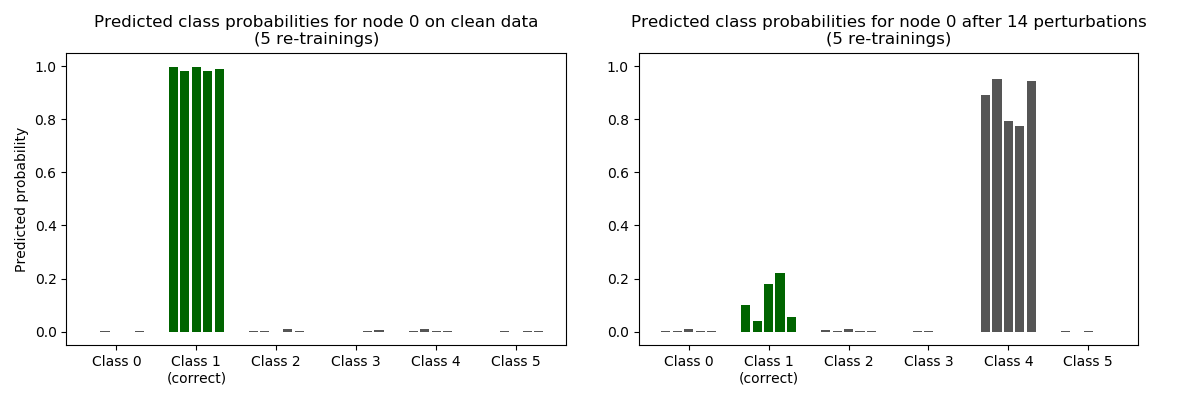

In [118]:
def make_xlabel(ix, correct):
    if ix==correct:
        return "Class {}\n(correct)".format(ix)
    return "Class {}".format(ix)

figure = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
center_ixs_clean = []
for ix, block in enumerate(class_distrs_clean.T):
    x_ixs= np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_clean.append(np.mean(x_ixs))
    color = '#555555'
    if ix == nettack.label_u:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)

ax=plt.gca()
plt.ylim((-.05, 1.05))
plt.ylabel("Predicted probability")
ax.set_xticks(center_ixs_clean)
ax.set_xticklabels([make_xlabel(k, nettack.label_u) for k in range(_K)])
ax.set_title("Predicted class probabilities for node {} on clean data\n({} re-trainings)".format(nettack.u, retrain_iters))

fig = plt.subplot(1, 2, 2)
center_ixs_retrain = []
for ix, block in enumerate(class_distrs_retrain.T):
    x_ixs= np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_retrain.append(np.mean(x_ixs))
    color = '#555555'
    if ix == nettack.label_u:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)


ax=plt.gca()
plt.ylim((-.05, 1.05))
ax.set_xticks(center_ixs_retrain)
ax.set_xticklabels([make_xlabel(k, nettack.label_u) for k in range(_K)])
ax.set_title("Predicted class probabilities for node {} after {} perturbations\n({} re-trainings)".format(nettack.u, n_perturbations, retrain_iters))
plt.tight_layout()
plt.show()

## Testing the look ahead algorithm

In [6]:
from src.nettack.GCN import *
from src.nettack.utils import *
from src.nettack.nettack import *
from src.nettack.replication import *

## Cora

### Direct attack with the greedy algorithm

Selecting 1 largest connected components
Number of training node : 247
Number of validation nodes : 249
Number of unlabeled (unknown) nodes : 1988


/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


converged after 28 iterations
Validation accuracy : 84.74%
Train accuracy : 100.00%
Unlabeled accuracy : 84.26%
-0.9824931 0.9999647 0.7845372
converged after 18 iterations
Validation accuracy : 83.94%
Train accuracy : 100.00%
Unlabeled accuracy : 83.20%


/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

<IPython.core.display.Javascript object>


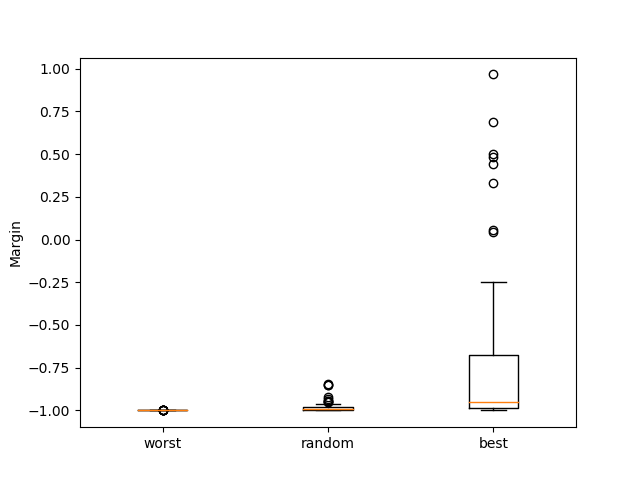

In [13]:
Ev = Evaluater()
Ev.load_dataset('src/data/cora.npz')
Ev.create_splits()
Ev.train_model(surrogate=False)

clean_margins = Ev.margins

margin_unlabeled = Ev.margins[Ev.split_unlabeled]
sorted_margins = np.argsort(margin_unlabeled)

worst_ids = Ev.split_unlabeled[sorted_margins[:10]].astype(np.int32)
best_ids = Ev.split_unlabeled[sorted_margins[-10:]].astype(np.int32)
random_ids = Ev.split_unlabeled[np.random.choice(sorted_margins[10:-10], size=20, replace=False)].astype(np.int32)

print(Ev.margins[worst_ids].mean(), Ev.margins[best_ids].mean(), Ev.margins[random_ids].mean())

Ev.train_model(surrogate=True)

worst_margins = Ev.produce_margins(worst_ids, direct=True, n_repeats=5, nb_process=0, features=False)
random_margins = Ev.produce_margins(random_ids, direct=True, n_repeats=5, nb_process=0, features=False)
best_margins = Ev.produce_margins(best_ids, direct=True, n_repeats=5, nb_process=0, features=False)

plt.figure()
plt.boxplot([worst_margins.flatten(), random_margins.flatten(), best_margins.flatten()],
            positions=[0, 1, 2], labels=['worst', 'random', 'best']);
plt.ylabel('Margin')
plt.savefig('figures/direct_margins_cora_struct.pdf', format='pdf')

<IPython.core.display.Javascript object>


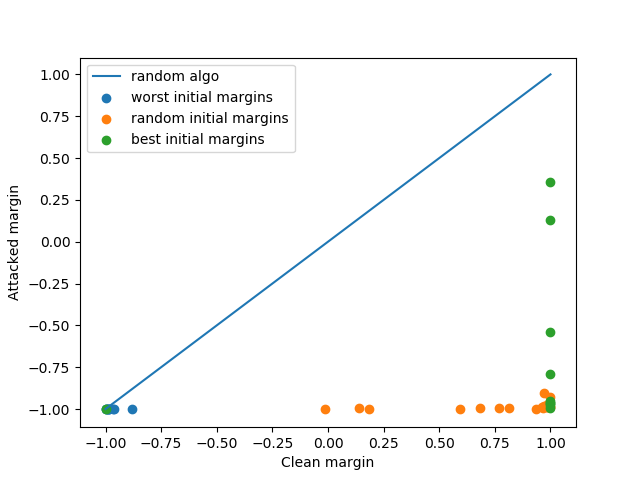

In [14]:
plt.figure()
plt.scatter(Ev.margins[worst_ids], worst_margins.mean(0), label='worst initial margins')
plt.scatter(Ev.margins[random_ids], random_margins.mean(0), label='random initial margins')
plt.scatter(Ev.margins[best_ids], best_margins.mean(0), label='best initial margins')
plt.plot([-1, 1], [-1, 1], label='random algo')
plt.xlabel('Clean margin')
plt.ylabel('Attacked margin')
plt.legend()
plt.savefig('figures/direct_margins_scatter_struct.pdf', format='pdf')

In [15]:
np.array(worst_margins).mean(), np.array(random_margins).mean(), np.array(best_margins).mean()

(-0.9998721528053284, -0.982778804898262, -0.6696120113134384)

### Indirect attacks

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

<IPython.core.display.Javascript object>


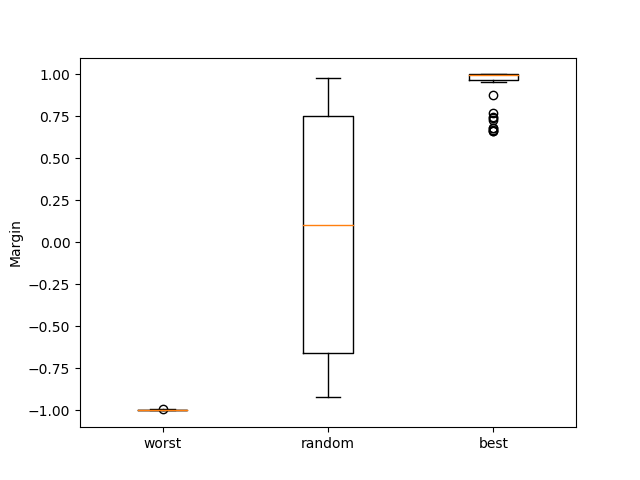

In [16]:
direct = False
worst_margins_in = Ev.produce_margins(worst_ids, direct=direct, n_repeats=5, nb_process=0, features=False)
random_margins_in = Ev.produce_margins(random_ids, direct=direct, n_repeats=5, nb_process=0, features=False)
best_margins_in = Ev.produce_margins(best_ids, direct=direct, n_repeats=5, nb_process=0, features=False)

plt.figure()
plt.boxplot([worst_margins_in.flatten(), random_margins_in.flatten(), best_margins_in.flatten()],
            positions=[0, 1, 2], labels=['worst', 'random', 'best']);
plt.ylabel('Margin')
plt.savefig('figures/indirect_margins_cora_struct.pdf', format='pdf')

<IPython.core.display.Javascript object>


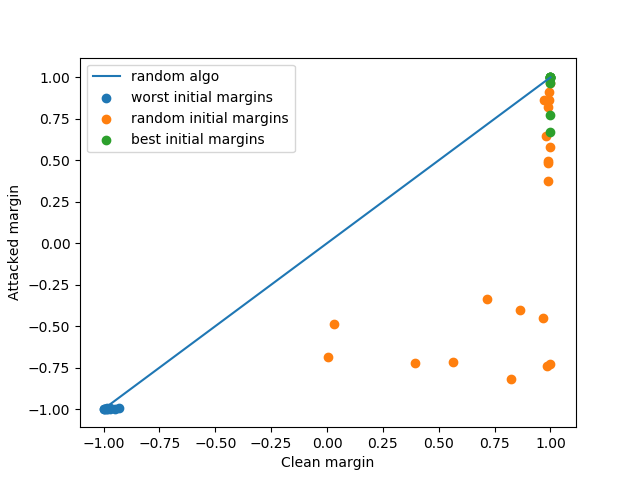

In [17]:
plt.figure()
plt.scatter(Ev.margins[worst_ids], worst_margins_in.mean(0), label='worst initial margins')
plt.scatter(Ev.margins[random_ids], random_margins_in.mean(0), label='random initial margins')
plt.scatter(Ev.margins[best_ids], best_margins_in.mean(0), label='best initial margins')
plt.plot([-1, 1], [-1, 1], label='random algo')
plt.xlabel('Clean margin')
plt.ylabel('Attacked margin')
plt.legend()
plt.savefig('figures/indirect_scatter_cora_struct.pdf', format='pdf')

In [18]:
np.array(worst_margins_in).mean(), np.array(random_margins_in).mean(), np.array(best_margins_in).mean()

(-0.9971737575531006, 0.045717949569225313, 0.9404712128639221)

### Direct attack with the look ahead algorithm

In [57]:
Ev = Evaluater(True, 40)
Ev.load_dataset('src/data/cora.npz')
Ev.create_splits()
Ev.train_model(surrogate=False)

clean_margins = Ev.margins

margin_unlabeled = Ev.margins[Ev.split_unlabeled]
sorted_margins = np.argsort(margin_unlabeled)

worst_ids = Ev.split_unlabeled[sorted_margins[:10]].astype(np.int32)
best_ids = Ev.split_unlabeled[sorted_margins[-10:]].astype(np.int32)
random_ids = Ev.split_unlabeled[np.random.choice(sorted_margins[10:-10], size=20, replace=False)].astype(np.int32)

print(Ev.margins[worst_ids].mean(), Ev.margins[best_ids].mean(), Ev.margins[random_ids].mean())

Ev.train_model(surrogate=True)

worst_margins = Ev.produce_margins(worst_ids, direct=True, n_repeats=5, nb_process=0)
random_margins = Ev.produce_margins(random_ids, direct=True, n_repeats=5, nb_process=0)
best_margins = Ev.produce_margins(best_ids, direct=True, n_repeats=5, nb_process=0)

plt.figure()
plt.boxplot([worst_margins.flatten(), random_margins.flatten(), best_margins.flatten()],
            positions=[0, 1, 2], labels=['worst', 'random', 'best']);
plt.ylabel('Margin')
plt.savefig('figures/direct_margins_cora_lookahead.pdf', format='pdf')

Selecting 1 largest connected components
Number of training node : 247
Number of validation nodes : 249
Number of unlabeled (unknown) nodes : 1988


/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


converged after 23 iterations
Validation accuracy : 83.53%
Train accuracy : 100.00%
Unlabeled accuracy : 84.05%
-0.983603 0.99987286 0.5918155
converged after 30 iterations
Validation accuracy : 82.73%
Train accuracy : 100.00%
Unlabeled accuracy : 81.59%


/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

KeyboardInterrupt: 

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

<IPython.core.display.Javascript object>


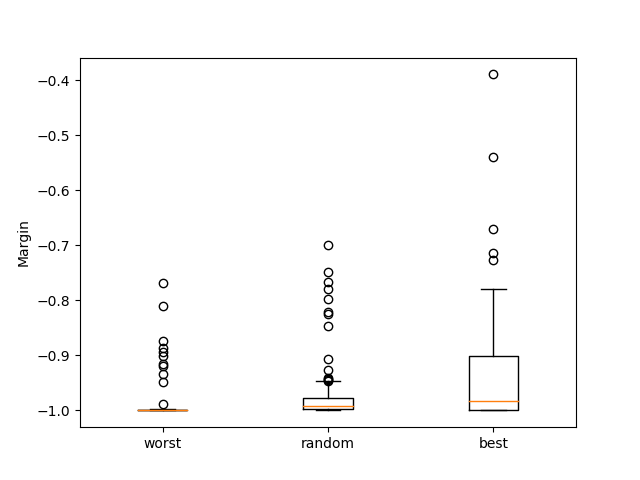

In [58]:
best_margins = Ev.produce_margins(best_ids, direct=True, n_repeats=5, nb_process=0)

plt.figure()
plt.boxplot([worst_margins.flatten(), random_margins.flatten(), best_margins.flatten()],
            positions=[0, 1, 2], labels=['worst', 'random', 'best']);
plt.ylabel('Margin')
plt.savefig('figures/direct_margins_cora_lookahead.pdf', format='pdf')

<IPython.core.display.Javascript object>


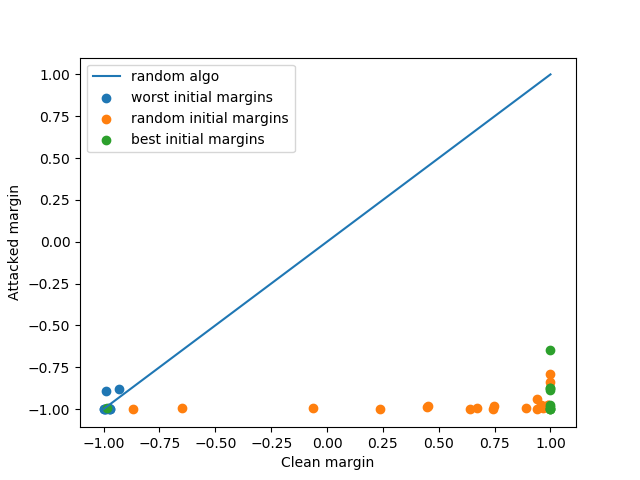

In [60]:
plt.figure()
plt.scatter(Ev.margins[worst_ids], worst_margins.mean(0), label='worst initial margins')
plt.scatter(Ev.margins[random_ids], random_margins.mean(0), label='random initial margins')
plt.scatter(Ev.margins[best_ids], best_margins.mean(0), label='best initial margins')
plt.plot([-1, 1], [-1, 1], label='random algo')
plt.xlabel('Clean margin')
plt.ylabel('Attacked margin')
plt.legend()
plt.savefig('figures/direct_margins_cora_lookahead2.pdf', format='pdf')

In [61]:
np.array(worst_margins).mean(), np.array(random_margins).mean(), np.array(best_margins).mean()

(-0.9766966271400451, -0.9698273581266403, -0.9237069755792617)

### Indirect attack with look ahead

In [7]:
Ev = Evaluater(True, 10)
Ev.load_dataset('src/data/cora.npz')
Ev.create_splits()
Ev.train_model(surrogate=False)

clean_margins = Ev.margins

margin_unlabeled = Ev.margins[Ev.split_unlabeled]
sorted_margins = np.argsort(margin_unlabeled)

worst_ids = Ev.split_unlabeled[sorted_margins[:10]].astype(np.int32)
best_ids = Ev.split_unlabeled[sorted_margins[-10:]].astype(np.int32)
random_ids = Ev.split_unlabeled[np.random.choice(sorted_margins[10:-10], size=20, replace=False)].astype(np.int32)

Ev.train_model(surrogate=True)

direct = False
best_margins_in = Ev.produce_margins(best_ids, direct=direct, n_repeats=3, nb_process=0)
worst_margins_in = Ev.produce_margins(worst_ids, direct=direct, n_repeats=3, nb_process=0)
random_margins_in = Ev.produce_margins(random_ids, direct=direct, n_repeats=3, nb_process=0)

plt.figure()
plt.boxplot([worst_margins_in.flatten(), random_margins_in.flatten(), best_margins_in.flatten()],
            positions=[0, 1, 2], labels=['worst', 'random', 'best']);
plt.ylabel('Margin')
plt.savefig('figures/indirect_margins_cora_lookahead.pdf', format='pdf')

Selecting 1 largest connected components
Number of training node : 247
Number of validation nodes : 249
Number of unlabeled (unknown) nodes : 1988


/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


converged after 51 iterations
Validation accuracy : 89.16%
Train accuracy : 100.00%
Unlabeled accuracy : 83.60%
converged after 36 iterations
Validation accuracy : 87.95%
Train accuracy : 100.00%
Unlabeled accuracy : 81.39%


/home/raphaelg/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected set' found for argument 'edges_set' of function 'compute_new_a_hat_uv'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "src/nettack/nettack.py", line 636:
@jit(nopython=True)
def compute_new_a_hat_uv(edge_ixs, node_nb_ixs, edges_set, twohop_ixs, values_before, degs, potential_edges, u):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetri

/home/raphaelg/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected set' found for argument 'edges_set' of function 'compute_new_a_hat_uv'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "src/nettack/nettack.py", line 636:
@jit(nopython=True)
def compute_new_a_hat_uv(edge_ixs, node_nb_ixs, edges_set, twohop_ixs, values_before, degs, potential_edges, u):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetri

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raphaelg/anaco

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


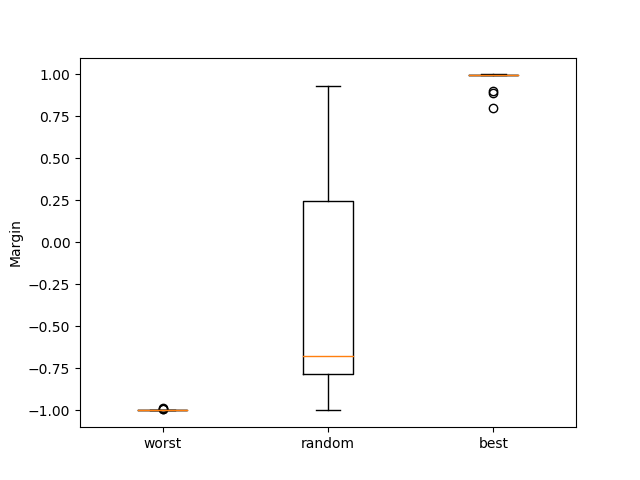

In [11]:
plt.figure()
plt.boxplot([worst_margins_in.flatten(), random_margins_in.flatten(), best_margins_in.flatten()],
            positions=[0, 1, 2], labels=['worst', 'random', 'best']);
plt.ylabel('Margin')
plt.savefig('figures/indirect_margins_cora_lookahead.pdf', format='pdf')

<IPython.core.display.Javascript object>


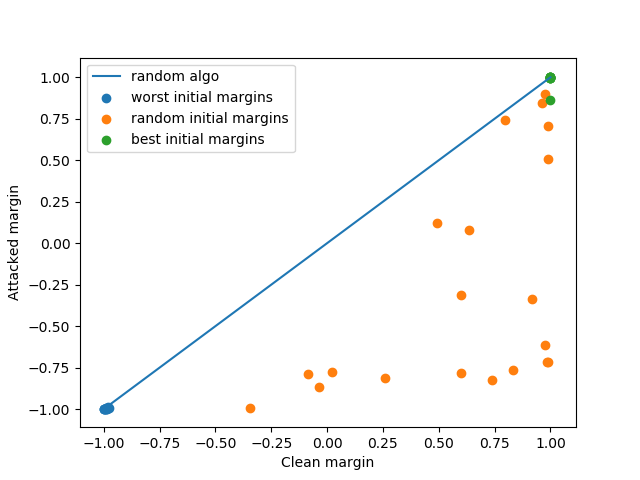

In [12]:
plt.figure()
plt.scatter(Ev.margins[worst_ids], worst_margins_in.mean(0), label='worst initial margins')
plt.scatter(Ev.margins[random_ids], random_margins_in.mean(0), label='random initial margins')
plt.scatter(Ev.margins[best_ids], best_margins_in.mean(0), label='best initial margins')
plt.plot([-1, 1], [-1, 1], label='random algo')
plt.xlabel('Clean margin')
plt.ylabel('Attacked margin')
plt.legend()
plt.savefig('figures/indirect_scatter_cora_lookahead.pdf', format='pdf')

In [10]:
np.array(worst_margins_in).mean(), np.array(random_margins_in).mean(), np.array(best_margins_in).mean()

(-0.9973011513551077, -0.2711173037687937, 0.9846856673558553)